In [1]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
exp_transform = T.ExpTransform()

In [4]:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform]) # Y = exp(X)

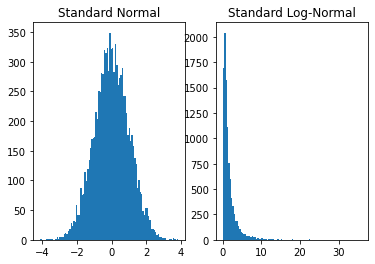

In [5]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([10000]).numpy(), bins=100)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([10000]).numpy(), bins=100)
plt.title('Standard Log-Normal')
plt.show()

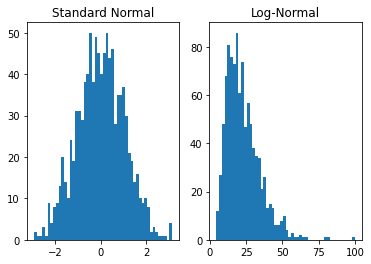

In [6]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

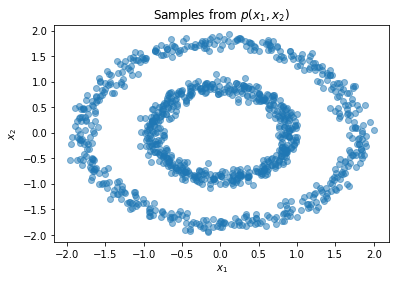

C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


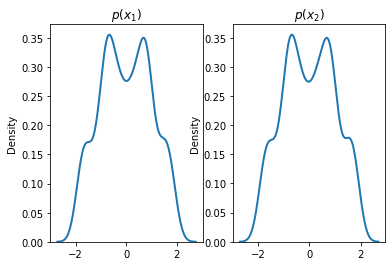

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [8]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
spline_transform2 = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform, spline_transform2])

<generator object Module.parameters at 0x000001C653EF4F90>


In [10]:
steps = 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(list(spline_transform.parameters()) + list(spline_transform2.parameters()), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.8673717975616455
step: 200, loss: 1.3126589059829712
step: 400, loss: 1.2695261240005493
step: 600, loss: 1.258980393409729
step: 800, loss: 1.2591326236724854
step: 1000, loss: 1.2516677379608154


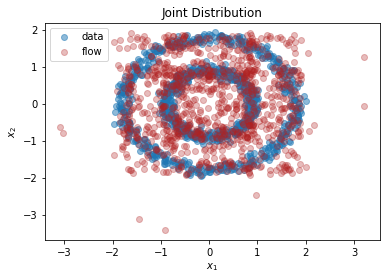

C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra

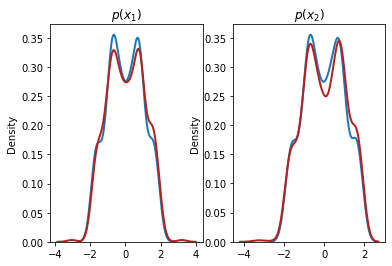

In [11]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.3)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

In [11]:
%%time

import flows.utils as flows

flow_dist, spline_transform = flows.normal2d_to_samples(torch.tensor(X, dtype=torch.float), steps=2001)

C:\Users\plain\Dropbox\university\21SS\IN2261 Bachelor's Thesis\code\demos\flows\utils.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float)


step: 0, loss: 3.9714431762695312
step: 200, loss: 1.9254339933395386
step: 400, loss: 1.8620845079421997
step: 600, loss: 1.7587785720825195
step: 800, loss: 1.7493051290512085
step: 1000, loss: 1.7387444972991943
step: 1200, loss: 1.7074016332626343
step: 1400, loss: 1.7088350057601929
step: 1600, loss: 1.7905771732330322
step: 1800, loss: 1.7823188304901123
step: 2000, loss: 1.7724930047988892
Wall time: 20.5 s


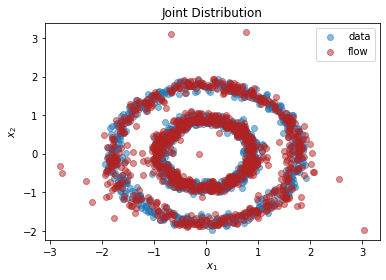

C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\plain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra

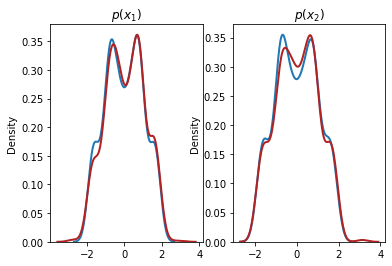

In [12]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()